In [2]:
import cv2
import glob
import numpy as np
from skimage import io
from random import randint
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [3]:
clases = list(glob.glob("101_ObjectCategories/*/"))
dic = {}
for i in range(len(clases)):
    nombreClase = clases[i].split('\\')[1]
    directorio = "101_ObjectCategories/"+nombreClase+"/*.jpg"
    archivos = list(glob.iglob(directorio, recursive=True))
    listaImagenes = []
    for j in range(len(archivos)):
        img = io.imread(archivos[j])
        listaImagenes.append(img)
    dic[nombreClase] = listaImagenes

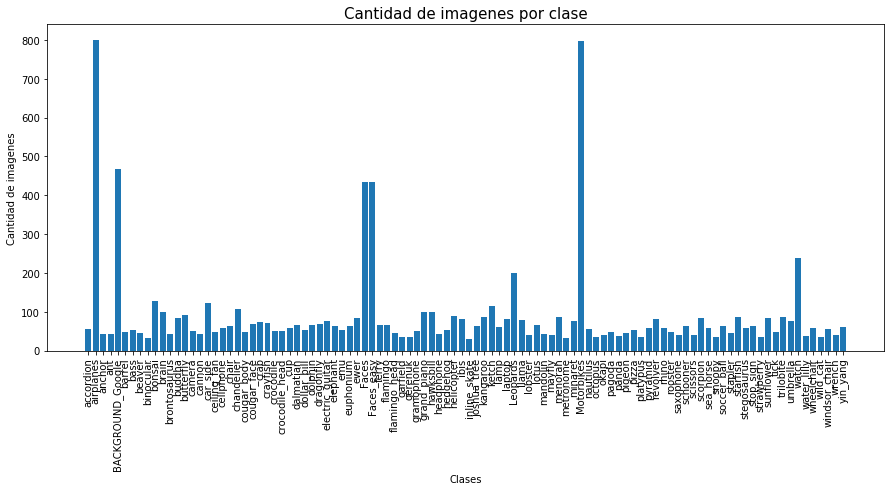

In [4]:
def graficaElementos(listaClases, listaAux):
    listaCuenta = []
    for i in range(len(listaClases)):
        valor = len(listaAux[i])
        listaCuenta.append(valor)
    plt.figure(figsize=(15, 6))
    plt.bar(listaClases, listaCuenta)
    plt.title("Cantidad de imagenes por clase",size=15)
    plt.xlabel("Clases")
    plt.xticks(rotation=90)
    plt.ylabel("Cantidad de imagenes")   
    
listaClases = list(dic.keys())
listaAux = list(dic.values())
graficaElementos(listaClases, listaAux)

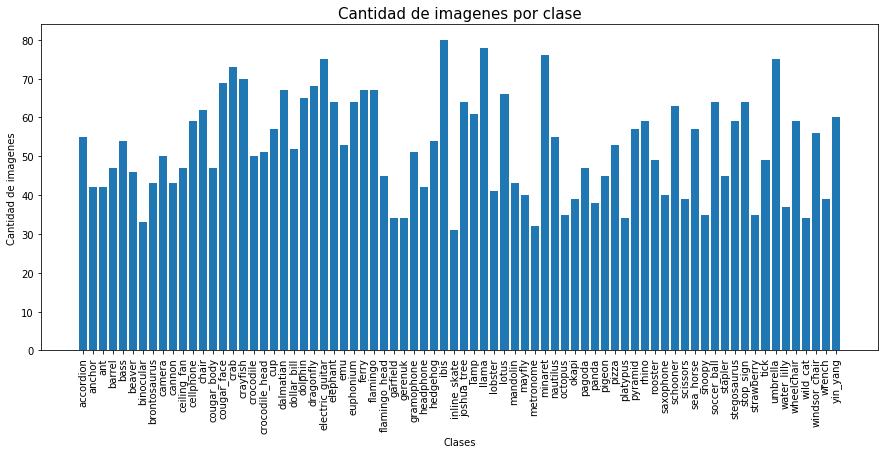

In [5]:
listaClases = list(dic.keys())
listaImagenes = list(dic.values())
listaCuenta = []
for i in range(len(listaClases)):
    valor = len(listaImagenes[i])
    if valor > 80:
        del dic[listaClases[i]]
listaClases = list(dic.keys())
listaAux = list(dic.values())
graficaElementos(listaClases, listaAux)

In [6]:
dicTrain = {}
dicValidation = {}
listaClases = list(dic.keys())
listaImagenes = list(dic.values())
for i in range(len(listaClases)):
    x_train, x_val = train_test_split(listaImagenes[i], test_size = 0.2, train_size = 0.8, shuffle = True)
    dicTrain[listaClases[i]] = x_train
    dicValidation[listaClases[i]] = x_val

In [7]:
listaClases = list(dicTrain.keys())
listaAux = []
listaTrain = list(dicTrain.values())
etiquetasTrain = []
imgTrain = []
for i in range(len(listaClases)):
    listaAux = listaTrain[i]
    for j in range(len(listaAux)):
        etiquetasTrain.append(i)
        imgTrain.append(listaAux[j])
listaAux = []
listaVal = list(dicValidation.values())
etiquetasVal = []
imgVal  = []
for k in range(len(listaClases)):
    listaAux = listaVal[k]
    for l in range(len(listaAux)):
        etiquetasVal.append(k)
        imgVal.append(listaAux[l])

4.3103967


C:\Users\usuario\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\usuario\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


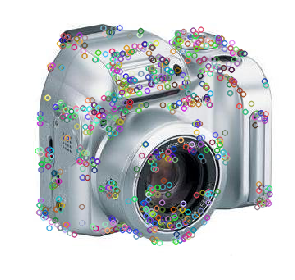

In [56]:
def compute_SIFT(imagen):
    #gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    gray = imagen
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    img = cv2.drawKeypoints(gray, kp, imagen)
    desNorm = preprocessing.normalize(des) 
    return img, desNorm

valor = randint(0, len(imgTrain) - 1)
image, des = compute_SIFT(imgTrain[valor])
plt.figure()
io.imshow(image)
plt.axis('off')
print(np.sum(des[0,:])) # No se porque no me da la suma igual a uno.

In [44]:
SIFT_train = np.zeros((20000, 128))
i = 0
while i < 20000:
    valor = randint(0, len(imgTrain)-1)
    try:
        image, des = compute_SIFT(imgTrain[valor])
    except:
        continue
    for j in range(np.shape(des)[0]):
        if i >= 20000:
            break
        SIFT_train[i,:] = des[j,:]
        i = i + 1
    
print(np.shape(SIFT_train))

(20000, 128)


In [29]:
kmeans = KMeans(n_clusters = 200, random_state = 0).fit(SIFT_train)
kmeans.labels_

array([ 76,  13, 170, ...,  87, 109, 136])

Text(0,0.5,'Frecuencia')

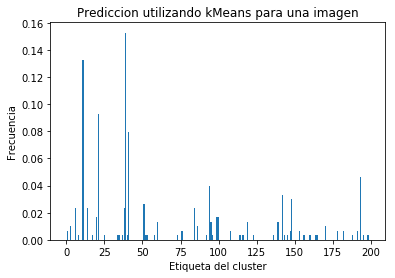

In [53]:
def get_bow(imagen):
    imgSIFT, descriptores = compute_SIFT(imagen)
    etiquetas = []
    for i in range(np.shape(descriptores)[0]):
        cercano = kmeans.predict([descriptores[i]])
        for j in range(len(cercano)):
            etiquetas.append(cercano[j])
    distribucion = np.zeros((1,200))
    for k in range(len(etiquetas)):
        distribucion[0,etiquetas[k]] = distribucion[0,etiquetas[k]] + 1
    return distribucion[0]/len(etiquetas)

valor = randint(0, len(imgTrain) - 1)
distribucion = get_bow(imgTrain[valor])
plt.figure()
plt.bar(range(200), distribucion)
plt.title('Prediccion utilizando kMeans para una imagen')
plt.xlabel('Etiqueta del cluster')
plt.ylabel('Frecuencia')

In [57]:
BOW_train = np.zeros((len(imgTrain),200))
etiquetasBOW_train = []
for i in range(len(imgTrain)):
    representacion = get_bow(imgTrain[i])
    etiquetasBOW_train.append(etiquetasTrain[i])
    BOW_train[i,:] = representacion    

In [58]:
prueba = randint(0,len(BOW_train))
print(np.sum(BOW_train[prueba]))

1.0


In [59]:
BOW_val = np.zeros((len(imgVal),200))
etiquetasBOW_val = []
for i in range(len(imgVal)):
    representacion = get_bow(imgVal[i])
    etiquetasBOW_val.append(etiquetasVal[i])
    BOW_val[i,:] = representacion  

In [61]:
prueba = randint(0,len(BOW_val))
print(np.sum(BOW_val[prueba]))

1.0


In [62]:
clf = LinearSVC(random_state = 0, tol = 1e-5)
clf.fit(BOW_train, etiquetasTrain)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

In [63]:
predTrain = []
for i in range(len(BOW_train)):
    predecidasT = clf.predict([BOW_train[i]])
    for j in range(len(predecidasT)):
        predTrain.append(predecidasT[j])
print(mean_absolute_error(etiquetasBOW_train, predTrain))
predVal = []
for i in range(len(BOW_val)):
    predecidasV = clf.predict([BOW_val[i]])
    for j in range(len(predecidasV)):
        predVal.append(predecidasV[j])
print(mean_absolute_error(etiquetasBOW_val, predVal))

19.36588459099556
19.704019488428745
